# Cancer Detection Kaggle Competition

The objective of this code is to utilize the image data provided as part of the Histopathologic Cancer Detection competition hosted on Kaggle. The image data includes pathology images for classification where the objective is to determine if each image shows metastatic cancer. This dataset is a modified version of the PatchCamelyon dataset. The code presented here utilizes Tensorflow through the neural network API, Keras.

### The Dataset
The Kaggle dataset is organized for model training and evaluation. It contains a '/train' directory with images for training, a '/test' directory for submitting predictions in the Kaggle competition, and a 'train_labels.csv' file that provides the actual labels for each image in the '/train' directory. Each image is labeled '1' if it depicts cancer and '0' if it does not.


*   Training images = 220,025
*   Testing images = 57,458



In [1]:
#Install packages
%%capture
!pip install tensorflow keras matplotlib pandas scikit-learn
from google.colab import files
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

Dowload the dataset using your Kaggle API key

In [2]:
#Download the dataset
# !pip install Kaggle #install kaggle API

#upload your Kaggle API key
files.upload()

#Kaggle API key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:46<00:00, 158MB/s]
100% 6.31G/6.31G [00:46<00:00, 144MB/s]


In [4]:
!mkdir -p "data"
!unzip -o histopathologic-cancer-detection.zip -d "/content/data" > /dev/null

Let's print out the total number of image files for the training and testing set to see if the download was successful.

In [5]:
from genericpath import isdir
directory = "/content/data"

for subdir in os.listdir(directory):
  subdir_path = os.path.join(directory, subdir)

  if os.path.isdir(subdir_path):
    files = 0

    for file in os.listdir(subdir_path):
      files += 1

    print(f"Quantity of image files in {subdir} = {files}")

Quantity of image files in train = 220025
Quantity of image files in test = 57458


## Data Loading
Load and organize the image files into usable dataframes.








In [6]:
train_path = "/content/data/train"
test_path = "/content/data/test"
labels_path = "/content/data/train_labels.csv"

Make 'train' and 'valid' dataframes containing the file id and label for the training images and then a dataframe containing just the file id for the testing images.

In [7]:
input_data = pd.read_csv(labels_path)
print(input_data.head())

input_data['id'] = input_data['id'].apply(lambda x: os.path.join(train_path, x))
input_data['id'] = input_data['id'].apply(lambda x: x + ".tif" )
print(input_data['id'].iloc[0])

X_train, X_valid, y_train, y_valid = train_test_split(input_data['id'], input_data['label'], test_size=0.2, random_state=42)
train_data = pd.DataFrame({'id': X_train, 'label': y_train})
valid_data = pd.DataFrame({'id': X_valid, 'label': y_valid})

test_labels = pd.DataFrame()
test_labels['id'] = [filename for filename in os.listdir(test_path)]
test_labels['id'] = test_labels['id'].apply(lambda x: os.path.join(test_path, x))
print(test_labels['id'].iloc[0])

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
/content/data/train/f38a6374c348f90b587e046aac6079959adf3835.tif
/content/data/test/56e7694b520017ab19d6f2819ab8efd07d5d03f8.tif


In [8]:
print(train_data.info())
print(valid_data.info(),"\n")

print("Total image files =",valid_data.shape[0]+train_data.shape[0])

<class 'pandas.core.frame.DataFrame'>
Index: 176020 entries, 2425 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      176020 non-null  object
 1   label   176020 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 44005 entries, 107796 to 119838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      44005 non-null  object
 1   label   44005 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
None 

Total image files = 220025


## Data Preprocessing
*   ImageDataGenerator = Keras class for preprocessing and augmentation of image data. Used to load images from a directory, apply transformations, and return the image data in a usaable form for training thorugh Keras.
> Data augmentation is meant to help models better generalize and avoid overfitting
*   flow_from_dataframe() = methods that loads images and labels from their dataframe to the ImageDataGenerator

In [9]:
# Set up the preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,        # normalize pixel values to [0,1]
                                   rotation_range=20,     # randomly rotate images by 20 degrees to help model learn invariant features
                                   shear_range=0.2,       # apply random shearing to images so model can learn with some deformations
                                   zoom_range=0.2,        # random zoom within the range so model can recognize objects when zoomed in or out
                                   horizontal_flip=True)  #random flipping to represent possibl orientations

valid_datagen = ImageDataGenerator(rescale=1./255)

# Convert the label column to strings
train_data['label'] = train_data['label'].astype(str)
valid_data['label'] = valid_data['label'].astype(str)

print(train_data.info())
print(valid_data.info())

# Create the generators
train_generator = valid_datagen.flow_from_dataframe(dataframe=train_data,
                                                    x_col="id",
                                                    y_col="label",
                                                    target_size=(224,224), #this matches image sizes to ResNet50 images
                                                    batch_size=200,
                                                    class_mode = "binary")

print(train_generator,"\n")

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_data,
                                                  x_col="id",
                                                  y_col="label",
                                                  target_size=(224,224),
                                                  batch_size=200,
                                                  class_mode= "binary",
                                                  shuffle=False)  # No shuffling for predictions

<class 'pandas.core.frame.DataFrame'>
Index: 176020 entries, 2425 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      176020 non-null  object
 1   label   176020 non-null  object
dtypes: object(2)
memory usage: 4.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 44005 entries, 107796 to 119838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      44005 non-null  object
 1   label   44005 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB
None
Found 176020 validated image filenames belonging to 2 classes.

Found 44005 validated image filenames belonging to 2 classes.


## Define and Implement ResNet
Use pre-trained ResNet50 to complete the training of the model. Here, the ResNet50 is a 50-layer pretrained CNN which has been trained on more than one million images in the ImageNet dataset.
### Pre-trained ResNet50
*   **include_top** - exlcude the last, fully connected layer from the pretrained CNN so custum model layers can be added.
*   **input_shape** - images are 32 x 32 in RGB
* **trainable layers** - Make all 50 layers trainable to fine-tune the pre-existing weights

### Custom Layers
* **base_model.output** - gets the output tensor from the base ResNet50 model
* **GlobalAveragePooling2D()** - applies global average pooling to the output of the base model
* **Dense(N, activation='relu')(x)** - adds a fully connected layer with N units followed by ReLU activation
* **Dropout(0.2)** - randomly sets 20% of input units to 0 at each layer in order to introduce regularization

### Output Layer
* **Dense(1, activation = 'sigmoid')(x)** - sets the output layer to a dense layer with the sigmoid activation function for the binary classification

### Model Compilation
* **optimizer** - utilize the Adam optimizer for efficient stochastic gradient descent
* **loss** - use 'binary_crossentropy' as the loss function, which is ideal for binary classification problems

### Learning Rate Scheduling
The initial learning rate is set, providing a starting point that is adjusted downward each time a specified number of steps, in this case, 1,000, is reached. The rate of this decay is controlled by a decay rate of 0.95. This reduction is applied in a staircase fashion, meaning the learning rate maintains a constant value for a set number of steps and drops abruptly at the specified interval.

### Hyperparameter Tuning
Perform systematic tuning of model hyperparameters including learning rate, batch size, and dropout rate. Iterate over predefined ranges of these parameters, recompiling and evaluating the model's performance with each combination to identify the optimal settings. The results of each configuration are logged for comparison and analysis.


In [10]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Activation
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
# from tensorflow.keras.optimizers import Adam
# import sys
# os.makedirs('/content/training_logs', exist_ok=True)
# os.makedirs('/content/model_summaries', exist_ok=True)
# os.makedirs('/content/params', exist_ok=True)

# # Define parameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.001],
#     'batch_size': [50, 1000],
#     'dropout_rate': [0.2, 0.5],
#     'epochs' : [10]
# }

# class DecayCounter(Callback):
#     def __init__(self):
#         super(DecayCounter, self).__init__()
#         self.last_lr = None
#         self.decays = 0

#     def on_epoch_end(self, epoch, logs=None):
#       current_lr = self.model.optimizer.learning_rate
#       print(f" Current learning rate: {current_lr.numpy():.5f}")
#       if self.last_lr is None:
#           self.last_lr = current_lr
#       else:
#           # Compare the current learning rate with the last known learning rate
#           if current_lr < self.last_lr:
#               self.decays += 1
#               print(f"Learning rate decayed from {self.last_lr:.5f} to {current_lr:.5f}. Decays = {self.decays}")
#           self.last_lr = current_lr

# results_df = pd.DataFrame(columns=['combo','learning_rate', 'batch_size', 'dropout_rate', 'epochs','accuracy','time'])
# combo = 0
# for lr in param_grid['learning_rate']:
#     for batch_size in param_grid['batch_size']:
#         for dropout_rate in param_grid['dropout_rate']:
#           for epochs in param_grid['epochs']:
#               start_time = time.time()
#               combo += 1

#               params_dict = {
#                   combo: {
#                   'learning_rate': lr,
#                   'batch_size': batch_size,
#                   'dropout_rate': dropout_rate
#                   }
#               }

#               # Model setup
#               base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#               for layer in base_model.layers:
#                 layer.trainable = True

#               x = GlobalAveragePooling2D()(base_model.output)
#               x = Dense(512)(x)
#               x = BatchNormalization()(x)
#               x = Activation('relu')(x)
#               x = Dropout(dropout_rate)(x)
#               x = Dense(256)(x)
#               x = BatchNormalization()(x)
#               x = Activation('relu')(x)
#               x = Dropout(dropout_rate)(x)

#               predictions = Dense(1, activation='sigmoid')(x)
#               model = Model(inputs=base_model.input, outputs=predictions)

#               #set up the Adam optimizer including learning rate scheduling/decay

#               lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= lr,
#                                                                            decay_steps=1000,          # Apply decay after these steps
#                                                                            decay_rate=0.95,             # Decay rate
#                                                                            staircase=True)             # Apply decay in a staircase function



#               decay_counter = DecayCounter()

#               # Compile model
#               model.compile(optimizer= Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

#               callbacks = [
#                   # BatchInspection(),
#                   EarlyStopping(monitor='val_loss', patience=3),
#                   ModelCheckpoint(f'model_{combo}.keras', save_best_only=True),
#                   CSVLogger(f'/content/training_logs/training_log_{combo}.csv', append=False, separator=','),
#                   decay_counter
#               ]

#               # Fit model
#               history = model.fit(
#                   train_generator,
#                   epochs= 10,
#                   validation_data=valid_generator,
#                   batch_size=int(batch_size),
#                   callbacks = callbacks
#               )

#               epochs_run = len(history.history['loss'])

#               # Get the best validation accuracy
#               best_accuracy = max(history.history['val_accuracy'])

#               train_time = time.time() - start_time

#               new_row = pd.DataFrame({
#                   'combo' : [combo],
#                   'learning_rate': [lr],
#                   'batch_size': [batch_size],
#                   'dropout_rate': [dropout_rate],
#                   'epochs run': [epochs_run],
#                   'decays': decay_counter.decays,
#                   'accuracy': [best_accuracy],
#                   'time': [train_time]
#               })

#               # Use concat to add the new row to results_df
#               results_df = pd.concat([results_df, new_row], ignore_index=True)

# # Save results to CSV
# results_df.to_csv('/content/params/hyperparameter_tuning_results.csv', index=False)

In [11]:
# print(results_df,"\n")
# sorted_results = results_df.sort_values(by = 'accuracy', ascending = False)
# best_params = sorted_results.iloc[0]
# print(best_params)
# best_combo = best_params['combo']
# model_final = load_model(f'model_{best_combo}.keras')

NameError: name 'results_df' is not defined

### Hyperparameter Tuning Results - Quick Load
Here you can download and visualize the results of the lengthly hyperparameter tuning process shown above. This code will download the performance data for the combinations of parameters shown above.

In [10]:
import gdown
url = 'https://drive.google.com/uc?id=12tCqiKFYbeT2uqlj4I5VZnQZXJxOSUR6'
output = 'hyperparam_tuning_results.csv'
gdown.download(url, output, quiet=False)
tuning_df = pd.read_csv('hyperparam_tuning_results.csv')
tuning_df['accuracy'] = tuning_df['accuracy'].round(4)
tuning_df['time (min)'] = (tuning_df['time']/60).round(1)
tuning_df.drop(columns = ['time'], inplace = True)

!pip install prettytable
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = tuning_df.columns.tolist()
for row in tuning_df.itertuples(index=False):
    x.add_row(row)
x.align = "l"
x.padding_width = 1

print(x)

Downloading...
From: https://drive.google.com/uc?id=12tCqiKFYbeT2uqlj4I5VZnQZXJxOSUR6
To: /content/hyperparam_tuning_results.csv
100%|██████████| 437/437 [00:00<00:00, 1.44MB/s]


+-------+---------------+------------+--------------+----------+------------+--------+------------+
| combo | learning_rate | batch_size | dropout_rate | accuracy | epochs run | decays | time (min) |
+-------+---------------+------------+--------------+----------+------------+--------+------------+
| 1     | 0.01          | 50         | 0.2          | 0.8724   | 8          | 7      | 38.1       |
| 2     | 0.01          | 50         | 0.5          | 0.8984   | 10         | 8      | 47.2       |
| 3     | 0.01          | 1000       | 0.2          | 0.9129   | 8          | 7      | 38.1       |
| 4     | 0.01          | 1000       | 0.5          | 0.9079   | 10         | 8      | 47.2       |
| 5     | 0.001         | 50         | 0.2          | 0.9455   | 10         | 8      | 47.3       |
| 6     | 0.001         | 50         | 0.5          | 0.9531   | 10         | 8      | 47.4       |
| 7     | 0.001         | 1000       | 0.2          | 0.9509   | 10         | 8      | 47.1       |


The results show that the optimal combination of tested hyperparamers is leanring rate = 0.001, batch size = 50, and droupout rate = 0.5. Early stopping was employed, therefore epochs were not tuned. This combination of parameters gave a validation accuracy 95.31%. However, the model took 47.4 minutes to train while Model 8 achieved similar accuracy in 38.1 minutes.


In [11]:
#Set optimal params
sorted_results = tuning_df.sort_values(by = 'accuracy', ascending = False)
best_params = sorted_results.iloc[0]
lr = best_params['learning_rate']
batch_size = best_params['batch_size']
dropout_rate = best_params['dropout_rate']
print(lr, batch_size, dropout_rate)

0.001 50.0 0.5


If needed, use this code to retrain a model using the optimal parameters found during parameter tuning.

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
import sys
os.makedirs('/content/training_logs', exist_ok=True)
os.makedirs('/content/params', exist_ok=True)

# Define parameter grid
param_grid = {
    'learning_rate': [0.001],
    'batch_size': [50],
    'dropout_rate': [0.5],
    'epochs' : [20]
}

class DecayCounter(Callback):
    def __init__(self):
        super(DecayCounter, self).__init__()
        self.last_lr = None
        self.decays = 0

    def on_epoch_end(self, epoch, logs=None):
      current_lr = self.model.optimizer.learning_rate
      print(f" Current learning rate: {current_lr.numpy():.5f}")
      if self.last_lr is None:
          self.last_lr = current_lr
      else:
          # Compare the current learning rate with the last known learning rate
          if current_lr < self.last_lr:
              self.decays += 1
              print(f"Learning rate decayed from {self.last_lr:.5f} to {current_lr:.5f}. Decays = {self.decays}")
          self.last_lr = current_lr

results_df = pd.DataFrame(columns=['combo','learning_rate', 'batch_size', 'dropout_rate', 'epochs','accuracy','time'])
combo = 0
for lr in param_grid['learning_rate']:
    for batch_size in param_grid['batch_size']:
        for dropout_rate in param_grid['dropout_rate']:
          for epochs in param_grid['epochs']:
              start_time = time.time()
              combo += 1

              params_dict = {
                  combo: {
                  'learning_rate': lr,
                  'batch_size': batch_size,
                  'dropout_rate': dropout_rate
                  }
              }

              # Model setup
              base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
              for layer in base_model.layers:
                layer.trainable = True

              x = GlobalAveragePooling2D()(base_model.output)
              x = Dense(512)(x)
              x = BatchNormalization()(x)
              x = Activation('relu')(x)
              x = Dropout(dropout_rate)(x)
              x = Dense(256)(x)
              x = BatchNormalization()(x)
              x = Activation('relu')(x)
              x = Dropout(dropout_rate)(x)

              predictions = Dense(1, activation='sigmoid')(x)
              model = Model(inputs=base_model.input, outputs=predictions)

              #set up the Adam optimizer including learning rate scheduling/decay

              lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= lr,
                                                                           decay_steps=1000,          # Apply decay after these steps
                                                                           decay_rate=0.95,             # Decay rate
                                                                           staircase=True)             # Apply decay in a staircase function



              decay_counter = DecayCounter()

              # Compile model
              model.compile(optimizer= Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

              callbacks = [
                  # BatchInspection(),
                  EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(f'model_final.keras', save_best_only=True),
                  CSVLogger(f'/content/training_logs/training_log_final.csv', append=False, separator=','),
                  decay_counter
              ]

              # Fit model
              history = model.fit(
                  train_generator,
                  epochs= epochs,
                  validation_data=valid_generator,
                  batch_size=int(batch_size),
                  callbacks = callbacks
              )

              epochs_run = len(history.history['loss'])

              # Get the best validation accuracy
              best_accuracy = max(history.history['val_accuracy'])

              train_time = time.time() - start_time

              new_row = pd.DataFrame({
                  'combo' : [combo],
                  'learning_rate': [lr],
                  'batch_size': [batch_size],
                  'dropout_rate': [dropout_rate],
                  'epochs run': [epochs_run],
                  'decays': decay_counter.decays,
                  'accuracy': [best_accuracy],
                  'time': [train_time]
              })

              # Use concat to add the new row to results_df
              results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save results to CSV
results_df.to_csv('/content/params/hyperparameter_tuning_results.csv', index=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9028 - loss: 0.2531 Current learning rate: 0.00100
881/881 ━━━━━━━━━━━━━━━━━━━━ 392s 355ms/step - accuracy: 0.9029 - loss: 0.2530 - val_accuracy: 0.8129 - val_loss: 0.4652
Epoch 2/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9479 - loss: 0.1439 Current learning rate: 0.00095
Learning rate decayed from 0.00100 to 0.00095. Decays = 1
881/881 ━━━━━━━━━━━━━━━━━━━━ 274s 310ms/step - accuracy: 0.9479 - loss: 0.1439 - val_accuracy: 0.8693 - val_loss: 0.3890
Epoch 3/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9586 - loss: 0.1176 Current learning rate: 0.00090
Learning rate decayed from 0.00095 to 0.00090. Decays = 2
881/881 ━━━━━━━━━━━━━━━━━━━━ 271s 308ms/step - accuracy: 0.9586 - loss: 0.1176 - val_accuracy: 0.7231 - val_loss: 1.2177
Epoch 4/20
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9643 - loss: 0.1005 Current learning rate: 0.00086
Learning rate decayed from 0.00090 to 0.00086

<ipython-input-12-fee498449312>:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


## Final Model - Quick Load
You can directly execute this section by downloading the pre-trained model from GitHub, bypassing the need for running the extensive hyperparameter tuning process. Below is the code to load the model configured with the optimal parameters identified during the hyperparameter tuning shown above.

In [13]:
#Load the model
!pip install gdown
import gdown
from tensorflow.keras.models import Model, load_model

url = 'https://drive.google.com/uc?id=1FANEtbU3FlN5elik4SuuyuHFCe1cOeMm' #use 'uc?id=' to trigger dowload insted of linking to Google Drive UI
output = 'model_final.keras'
gdown.download(url, output, quiet=False)

model = load_model(output)

Downloading...
From (original): https://drive.google.com/uc?id=1FANEtbU3FlN5elik4SuuyuHFCe1cOeMm
From (redirected): https://drive.google.com/uc?id=1FANEtbU3FlN5elik4SuuyuHFCe1cOeMm&confirm=t&uuid=40be20ed-f597-4ee2-b38e-e694610216ca
To: /content/model_final.keras
100%|██████████| 298M/298M [00:01<00:00, 194MB/s]


Here is the model architecture. Note the the model is named 'functional_13' because I retrained the model outside of the 12 models within the hyperparamter tuning script.

In [14]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 74,205,060 (283.07 MB)

 Trainable params: 24,716,801 (94.29 MB)

 Non-trainable params: 54,656 (213.50 KB)

 Optimizer params: 49,433,603 (188.57 MB)

None


Let's take a look at the model's validation and loss over the training epochs. Below, we will download the results found from previous training to avoid the need to run hyperparameter tuning in order to generate the results.

In [15]:
url = 'https://drive.google.com/uc?id=17jhAMxzz87iV2t-EP94YvQyvpZF8pPu4'
output = 'training_log_final.csv'
gdown.download(url, output, quiet=False)
training_log_df = pd.read_csv('training_log_final.csv')

Downloading...
From: https://drive.google.com/uc?id=17jhAMxzz87iV2t-EP94YvQyvpZF8pPu4
To: /content/training_log_final.csv
100%|██████████| 921/921 [00:00<00:00, 3.14MB/s]


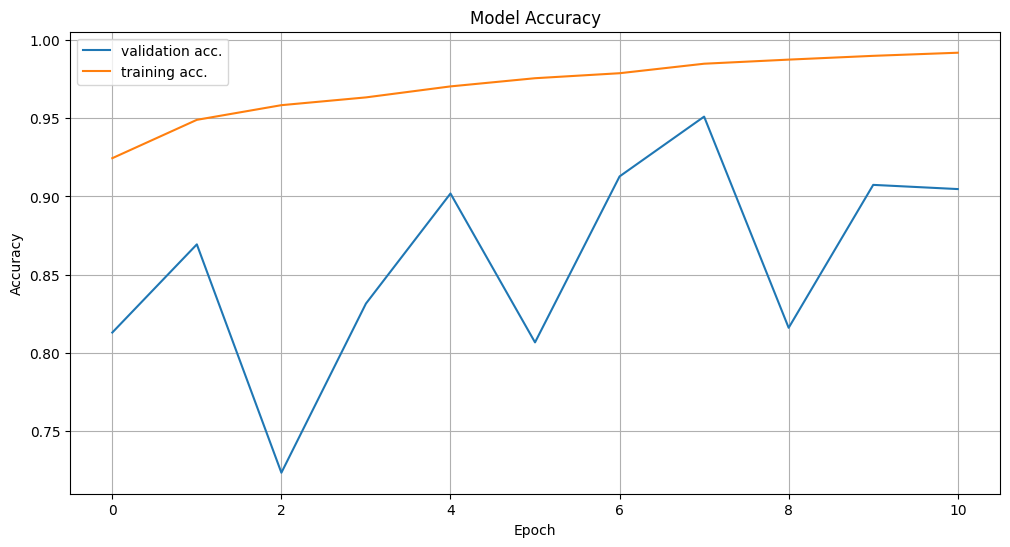

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(training_log_df['epoch'], training_log_df['val_accuracy'], label = 'validation acc.')
plt.plot(training_log_df['epoch'], training_log_df['accuracy'], label = 'training acc.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

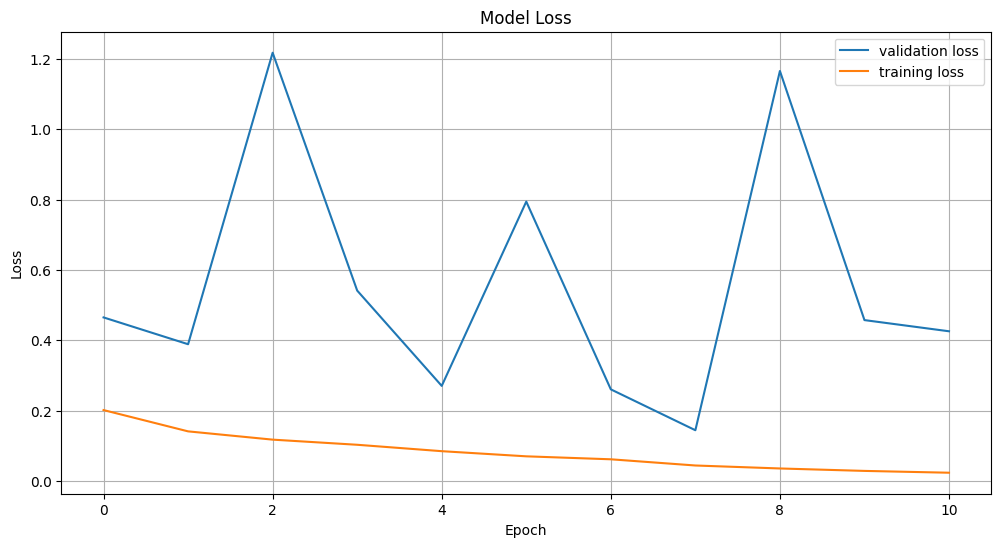

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(training_log_df['epoch'], training_log_df['val_loss'], label = 'validation loss')
plt.plot(training_log_df['epoch'], training_log_df['loss'], label = 'training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

## Predict

In [18]:
test_path = "/content/data/test"
test_data = pd.DataFrame()
test_data['id'] = [filename for filename in os.listdir(test_path)]
test_data['id'] = test_data['id'].apply(lambda x: os.path.join(test_path, x))
# print(test_data['id'].iloc[0])

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  x_col="id",
                                                  target_size=(224,224),
                                                  batch_size=int(batch_size),
                                                  class_mode= None,
                                                  shuffle=False)

Found 57458 validated image filenames.


In [22]:
# Predict on test data
test_predictions = model.predict(test_generator)

# Convert predictions to binary labels (0 or 1)
predicted_labels = (test_predictions > 0.5).astype("int32")

# Save predictions to file
os.makedirs('/content/predictions' , exist_ok=True)
prediction_df = pd.DataFrame({'id': test_data['id'], 'label': predicted_labels.flatten()})
prediction_df['id'] = prediction_df['id'].apply(lambda x: x.split('/')[-1].split('.')[0])
prediction_df.to_csv('/content/predictions/predictions.csv', index=False)

1150/1150 ━━━━━━━━━━━━━━━━━━━━ 60s 52ms/step


# Results
After submitting the predictions.csv file to to Kaggle Competition page at I was able to achieve a private score of 0.8537 and a public score of 0.8943. Please see the subimission screenshot below.

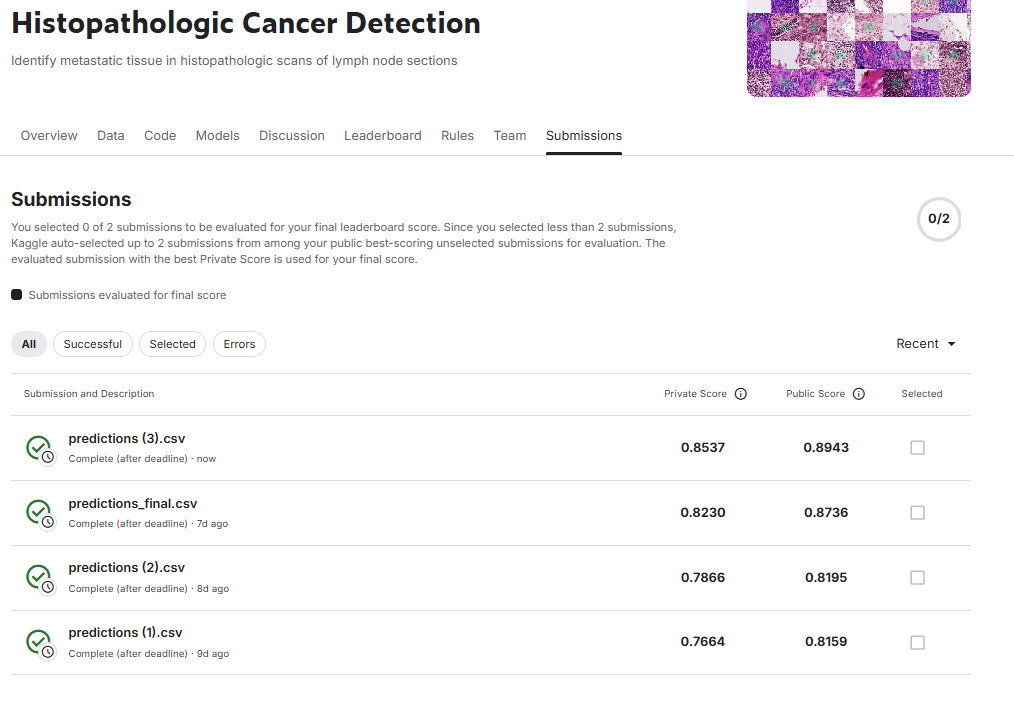

## Future Work
This code represents an introductory investigation into the machine learning problem presented in the Histopathologic Cancer Detection competition. Much more work could be done to tune hyperparameters, including the addition of more parameters, such as decay rate, and more values of each parameter.

In addition, the architecture of the nueral network should be looked at. I chose to use a pretrained CNN (ResNet50) with the addition of two dense layers on top.